In [1]:
try:
     from dlroms import *
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import *

/home/frabet/.local/lib/python3.10/site-packages/dlroms/fespaces.py:48: UserWarning: Either dolfin or fenics are not available. Some functions might not be available or work as expected.
  warnings.warn("Either dolfin or fenics are not available. Some functions might not be available or work as expected.")


In [2]:
from dlroms import *
# from dlroms.gp import GaussianRandomField
from geogp import GaussianRandomField
import numpy as np
from dolfin import *
from IPython.display import clear_output as clc

ModuleNotFoundError: No module named 'dolfin'

### Setup

FE space dimension: 1277


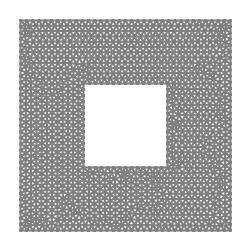

In [2]:
# Domain definition

# domain = fe.circle((0.0, 0.0), 1) - fe.circle((0.0, 0.0), 0.4)
domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.03)
V = fe.space(mesh, 'CG', 1)
clc()

plt.figure(figsize=(3, 3))
fe.plot(mesh)

print('FE space dimension:', V.dim())

In [18]:
# Input random field definition

l = 0.1 # length scale
ker = lambda r: np.exp(- r ** 2 / l)
KLE_dims = [10, 50, 500, 4255]
# K = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[1]) # Euclidean version
K_geo = GaussianRandomField(domain, mesh, kernel=ker, upto=KLE_dims[0]) # the dlrom version DOES NOT WORK (gmsh vs mshr?)
clc()

In [20]:
test_sample

array([nan, nan, nan, ..., nan, nan, nan])

RuntimeError: First argument should be either a dolfin.cpp.mesh.Mesh or a structure containing the dof values of some function (in which case 'space' must be != None).

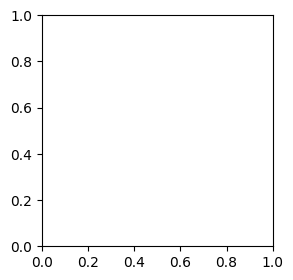

In [19]:
# test_sample = K.sample(0)
test_sample = K_geo.sample(0)

plt.figure(figsize=(3, 3))
fe.plot(test_sample, V, cmap='jet')

### Darcy flow

The Darcy flow equation is solved using **mixed finite elements** with third-order Raviartâ€“Thomas elements for the velocity, and fourth-order discontinuous elements for the pressure.

In [37]:
# Snapshot generation

def Darcy(K, V, mesh):
    """
    Solve the Darcy problem for a given instance of the input random field.
    Args:
        K, input random field
        V, FE space for the input random field
        mesh, input mesh
    """
    r = 10 # source rate
    w = 0.125 # source size

    # Function spaces
    # RT = FunctionSpace(mesh, "RT", 3)
    # DG = FunctionSpace(mesh, "DG", 4)
    # W  = MixedFunctionSpace([RT, DG]) # DEPRECATED
    RT_elem = FiniteElement("RT", mesh.ufl_cell(), 3)
    DG_elem = FiniteElement("DG", mesh.ufl_cell(), 3)
    W_elem = MixedElement([RT_elem, DG_elem])
    W = FunctionSpace(mesh, W_elem) # mixed function space

    # Trial and test functions
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    # Injection term
    class Injection(UserExpression):
        def __init__(self, w, r, **kwargs):
            self.w = w
            self.r = r
            super().__init__(**kwargs)

        def eval(self, values, x):
            if abs(x[0] - 0.5 * self.w) <= 0.5 * w and abs(x[1] - 0.5 * self.w) <= 0.5 * w:
                values[0] = self.r
            elif abs(x[0] + 0.5 * self.w - 1) <= 0.5 * w and abs(x[1] + 0.5 * self.w - 1) <= 0.5 * w:
                values[0] = - self.r
            else:
                values[0] = 0

        def value_shape(self):
            return ()
    
    f = Injection(w, r, degree=0) # degree?

    # Gaussian field
    class Field(UserExpression):
        def __init__(self, field, **kwargs):
            self.field = field
            super().__init__(**kwargs)

        def eval(self, values, x):
            print(x)
            values[0] = 0

        def value_shape(self):
            return ()

    print(mesh.coordinates())
    # Gaussian random field as function
    k = Field(K.sample(0), degree=1)

    # Variational problem
    a = (dot(u, v) - k * dot(p, div(v)) - dot(u, grad(q))) * dx
    L = f * q * dx + p * dx - k * p * v * ds # Ok to impose int(p) = 0 like this?

    w = Function(W)
    solve(a == L, w)
    (u, p) = w.split()

    plot(p, interactive=True)

    return u, p

In [38]:
u, p = Darcy(K, V, mesh)

[[0.         0.        ]
 [1.         0.        ]
 [1.         1.        ]
 ...
 [0.73688455 0.5016909 ]
 [0.49829314 0.2631708 ]
 [0.04068727 0.94554525]]
Can only integrate scalar expressions. The integrand is a tensor expression with value shape (2,) and free indices with labels ().


UFLException: Can only integrate scalar expressions. The integrand is a tensor expression with value shape (2,) and free indices with labels ().